In [1]:
%%capture
!pip install transformers datasets evaluate albumentations timm torchvision
!pip install -U opencv-python accelerate

In [2]:
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import albumentations
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations
import numpy as np
import torch
import torchvision
from torchvision.ops import box_convert
from torchvision.transforms.functional import pil_to_tensor

In [3]:
DATASET_ID = "cppe-5"
cppe5 = load_dataset(DATASET_ID)

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

In [4]:
cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [5]:
cppe5["train"][0]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

In [6]:
id2label = {i:v for i, v in enumerate(cppe5["train"].features["objects"].feature["category"].names)}
label2id = {v:k for k, v in id2label.items()}

In [7]:
def show_example(ds, split="train", idx=0):
    sample = ds[split][idx]
    img = sample["image"]
    plt.imshow(img)
    ax = plt.gca()
    for i, box in enumerate(sample["objects"]["bbox"]):
        x, y, w, h = box
        ax.add_patch(plt.Rectangle((x,y), w, h, fill=False, color="red"))
        ax.text(x, y, f"{id2label[sample['objects']['category'][i]]}")
    plt.show()

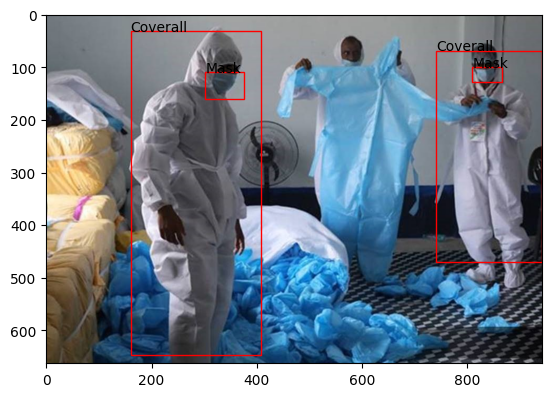

In [ ]:
show_example(cppe5)

In [8]:
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx]
cppe5["train"] = cppe5["train"].select(keep)

In [9]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [10]:
train_ds = cppe5["train"]

In [20]:
def ds_transform(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):

        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"],category=objects["category"])
        area.append(objects["area"])
        img = out["image"].transpose(2,0,1)/255
        images.append(img)
        bboxes.append(list(map(lambda x:list(x), out["bboxes"])))
        categories.append(out["category"])

    return {"image_id":image_ids, "area":area, "image":images, "bbox":bboxes, "category":categories}

In [21]:
ds = train_ds.with_transform(ds_transform)

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=6)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [27]:
targets = []
for i in range(len(ds)):
    d = {}
    sample = ds[i]
    d["boxes"] = box_convert(torch.tensor(sample["bbox"],dtype=torch.float32),"xywh", "xyxy")
    d["labels"] = torch.tensor(sample["category"])
    targets.append(d)

In [28]:
inputs = list(map(lambda x:torch.tensor(x,dtype=torch.float32), ds[:2]["image"]))
t = targets[:2]

In [29]:
model.train()
model.float()
print(model(inputs, t))

{'loss_classifier': tensor(1.8209, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0473, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.6882, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0635, grad_fn=<DivBackward0>)}


In [43]:
for name, mod in model.named_modules():
    print(name)


transform
backbone
backbone.body
backbone.body.conv1
backbone.body.bn1
backbone.body.relu
backbone.body.maxpool
backbone.body.layer1
backbone.body.layer1.0
backbone.body.layer1.0.conv1
backbone.body.layer1.0.bn1
backbone.body.layer1.0.conv2
backbone.body.layer1.0.bn2
backbone.body.layer1.0.conv3
backbone.body.layer1.0.bn3
backbone.body.layer1.0.relu
backbone.body.layer1.0.downsample
backbone.body.layer1.0.downsample.0
backbone.body.layer1.0.downsample.1
backbone.body.layer1.1
backbone.body.layer1.1.conv1
backbone.body.layer1.1.bn1
backbone.body.layer1.1.conv2
backbone.body.layer1.1.bn2
backbone.body.layer1.1.conv3
backbone.body.layer1.1.bn3
backbone.body.layer1.1.relu
backbone.body.layer1.2
backbone.body.layer1.2.conv1
backbone.body.layer1.2.bn1
backbone.body.layer1.2.conv2
backbone.body.layer1.2.bn2
backbone.body.layer1.2.conv3
backbone.body.layer1.2.bn3
backbone.body.layer1.2.relu
backbone.body.layer2
backbone.body.layer2.0
backbone.body.layer2.0.conv1
backbone.body.layer2.0.bn1
bac

In [44]:
model.get_submodule("backbone.body.layer4")

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): FrozenBatchNorm2d(512, eps=1e-05)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): FrozenBatchNorm2d(512, eps=1e-05)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): FrozenBatchNorm2d(2048, eps=1e-05)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): FrozenBatchNorm2d(2048, eps=1e-05)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): FrozenBatchNorm2d(512, eps=1e-05)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): FrozenBatchNorm2d(512, eps=1e-05)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): FrozenBatchNorm2d(204